In [1]:
# environment
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from scipy.signal import butter, filtfilt, find_peaks
from scipy.fft import fft, fftfreq
from scipy.integrate import cumulative_trapezoid
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Settings
sampling_rate = 30  # Hz
duration_minutes = 10
samples_per_subject = sampling_rate * 60 * duration_minutes
timestamps = np.arange(0, samples_per_subject) / sampling_rate
num_concussion = 20
num_control = 20
output_dir = "synthetic_data"
os.makedirs(output_dir, exist_ok=True)

def generate_sensor_data(label):
    """Simulates realistic back and thigh sensor data."""
    base_gravity = 9.8
    noise_scale = 0.3 if label == "control" else 1.2
    drift_factor = 0.0 if label == "control" else 0.002
    tremor_amp = 0.0 if label == "control" else 0.4

    time = timestamps
    drift = drift_factor * np.arange(samples_per_subject)

    # Simulate each axis
    def axis_data(base=0.0):
        signal = np.random.normal(loc=base, scale=noise_scale, size=samples_per_subject)
        if label == "concussion":
            tremor = tremor_amp * np.sin(2 * np.pi * 3 * time)  # 3Hz tremor-like wave
            signal += tremor + drift
        return signal

    data = {
        "Timestamp": time,
        "X": axis_data(),
        "Y": axis_data(),
        "Z": axis_data(base=base_gravity),
        "label": [label] * samples_per_subject
    }
    return pd.DataFrame(data)

# Generate data
for i in range(num_control):
    df = generate_sensor_data("control")
    df.to_csv(os.path.join(output_dir, f"control_{i+1:02d}.csv"), index=False)

for i in range(num_concussion):
    df = generate_sensor_data("concussion")
    df.to_csv(os.path.join(output_dir, f"concussion_{i+1:02d}.csv"), index=False)

print(f"Synthetic data with realistic abnormalities saved in '{output_dir}'")

Synthetic data with realistic abnormalities saved in 'synthetic_data'


In [3]:
# fourier fast tranform and finding predominent frequency
def compute_fft(signal, fs=30.1):
    N = len(signal)
    freq = fftfreq(N, d=1/fs)[:N // 2] 
    fft_values = np.abs(fft(signal))[:N // 2]
    return fft_values, freq

In [4]:
# bandpass filter
def bandpass_filter(data, lowcut, highcut, fs, order):
    nyquist = 0.5 * fs  
    low, high = lowcut / nyquist, highcut / nyquist
    b, a = butter(order, [low, high], btype='band', analog=False)
    return filtfilt(b, a, data)

In [5]:
# harmonic ratio calc
def harmonic_ratio(signal, fs=30.1):
    fft_values, freq = compute_fft(signal, fs)
    
    # fundamental frequency based on peaks
    peaks, _ = find_peaks(fft_values, height=np.max(fft_values) * 0.05)  
    if len(peaks) == 0:
        return None, [] 
    
    step_freq = freq[peaks[0]]
    
    # harmonics integer multiples of fundamental frequencies
    harmonics = np.arange(step_freq, max(freq), step_freq)
    harmonic_amplitudes = [fft_values[np.argmin(np.abs(freq - h))] for h in harmonics[:10]]
    even_harmonics = harmonic_amplitudes[1::2]  
    odd_harmonics = harmonic_amplitudes[0::2]

    HR = np.sum(even_harmonics) / np.sum(odd_harmonics) if np.sum(odd_harmonics) > 0 else None
    return HR, harmonic_amplitudes

In [6]:
# process harmonic folder
def process_folder_harmonic(folder_path, axes={'X': 'AP', 'Y': 'VT', 'Z': 'ML'}):
    results = []
    harmonics_data = []
    sampling_rate = 30.1  

    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            data = pd.read_csv(file_path)

            try:
                data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')
            except Exception:
                continue

            data = data.dropna(subset=['Timestamp'])
            data = data.sort_values(by='Timestamp')

            start_time = data['Timestamp'].iloc[0]
            end_time = start_time + pd.Timedelta(minutes=10)
            data = data[data['Timestamp'] <= end_time]
            
            subject_name = filename[:-4] + '.gt3x' 
            result = {'Filename': filename, 'subject': subject_name}

            for axis, axis_type in axes.items():
                if axis in data.columns:
                    filtered_signal = bandpass_filter(data[axis].dropna().values, 0.3, 15, sampling_rate, order=3)
                    harmonic_ratio_value, harmonic_amplitudes = harmonic_ratio(filtered_signal, sampling_rate)

                    result[f'Harmonic_Ratio_{axis}'] = harmonic_ratio_value

                    for i, amplitude in enumerate(harmonic_amplitudes, start=1):
                        harmonics_data.append({
                            'Filename': filename,
                            'subject': subject_name,
                            'Axis': axis,
                            'Harmonic': i,
                            'Amplitude': amplitude
                        })

            results.append(result)

    results_df = pd.DataFrame(results)
    harmonics_df = pd.DataFrame(harmonics_data)
    
    return results_df, harmonics_df

In [7]:
def prepare_harmonic_ratio_data(harmonics_df_dem):
    # make a true copy up‐front so we’re not touching a slice
    harmonics_df_dem = harmonics_df_dem.copy()

    # keep only the first 10 harmonics
    harmonics_df_dem = harmonics_df_dem[harmonics_df_dem["Harmonic"] <= 10]

    # grab the fundamental (H=1) amplitude by Axis & group
    fundamental_amplitude = (
        harmonics_df_dem
        .loc[harmonics_df_dem["Harmonic"] == 1]
        .set_index(["Axis", "group"])["Amplitude"]
    )

    harmonics_df_dem = harmonics_df_dem.merge(
        fundamental_amplitude.rename("Fundamental_Amplitude"),
        on=["Axis", "group"],
        how="left"
    )

    # fillna by assignment instead of inplace
    harmonics_df_dem["Fundamental_Amplitude"] = \
        harmonics_df_dem["Fundamental_Amplitude"].fillna(1)

    # compute the ratio
    harmonics_df_dem["Harmonic_Ratio"] = (
        harmonics_df_dem["Amplitude"] 
        / (harmonics_df_dem["Fundamental_Amplitude"] + 1e-6)
    )

    # if you want to fill any remaining NaNs (e.g. zero amplitude cases)
    harmonics_df_dem["Harmonic_Ratio"] = \
        harmonics_df_dem["Harmonic_Ratio"].fillna(0)

    return harmonics_df_dem

In [8]:
# plot harmonic ratios
def plot_harmonic_ratios(harmonics_df_dem):
    axes = ['X', 'Y', 'Z']
    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    
    for i, axis in enumerate(axes):
        subset = harmonics_df_dem[harmonics_df_dem['Axis'] == axis]
        
        if subset.empty:
            print(f"Warning: No data available for {axis}-axis.")
            continue
        
        avg_subset = subset.groupby(["Harmonic", "group"], as_index=False).mean(numeric_only=True)
        std_subset = subset.groupby(["Harmonic", "group"], as_index=False).std(numeric_only=True)
        
        sns.lineplot(ax=axs[i], data=avg_subset, x="Harmonic", y="Harmonic_Ratio", hue="group")
        
        axs[i].set_title(f"Harmonic Ratios for {axis}-Axis")
        axs[i].set_xlabel("Harmonic Number")
        axs[i].set_ylabel("Harmonic Ratio")
        axs[i].grid(True)
    
    plt.tight_layout()
    plt.show()

In [9]:
# plot by axis
def plot_average_harmonic_ratio_per_axis(harmonics_df_dem):

    avg_harmonic_ratio = harmonics_df_dem.groupby(["Axis", "group"])[["Harmonic_Ratio"]].mean().reset_index()
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=avg_harmonic_ratio, x="group", y="Harmonic_Ratio", hue="Axis")
    plt.title("Average Harmonic Ratio Across First 10 Harmonics by Group and Axis")
    plt.xlabel("Group")
    plt.ylabel("Average Harmonic Ratio")
    plt.legend(title="Axis")
    plt.grid(True)
    plt.show()

In [10]:
# read folder
folder_path = "synthetic_data/" 
results_df, harmonics_df = process_folder_harmonic(folder_path, axes={'X': 'LL', 'Y': 'CC', 'Z': 'AP'})

In [11]:
bctt_path = "bctt-time.csv"
bctt = pd.read_csv(bctt_path)

In [12]:
# merging with bctt
results_df_dem = pd.merge(results_df, bctt, on='subject')
harmonics_df_dem = pd.merge(harmonics_df, bctt, on='subject')

In [13]:
harmonics_df

,Filename,subject,Axis,Harmonic,Amplitude
0,concussion_01.csv,concussion_01.gt3x,X,1,83.348948
1,concussion_01.csv,concussion_01.gt3x,X,2,225.837631
2,concussion_01.csv,concussion_01.gt3x,X,3,102.535951
3,concussion_01.csv,concussion_01.gt3x,X,4,57.419549
4,concussion_01.csv,concussion_01.gt3x,X,5,105.676298
...,...,...,...,...,...
1195,control_20.csv,control_20.gt3x,Z,6,35.763525
1196,control_20.csv,control_20.gt3x,Z,7,28.858863
1197,control_20.csv,control_20.gt3x,Z,8,28.129036
1198,control_20.csv,control_20.gt3x,Z,9,8.266142


In [14]:
harmonics_df_dem = prepare_harmonic_ratio_data(harmonics_df_dem)

In [15]:
harmonics_df_dem

,Filename,subject,Axis,Harmonic,Amplitude,date,start time,end time,duration,group,age,sex,Fundamental_Amplitude,Harmonic_Ratio
0,concussion_01.csv,concussion_01.gt3x,X,1,83.348948,2019-12-10,8:55:37,9:10:35,0:14:58,concussion,16,1,83.348948,1.000000
1,concussion_01.csv,concussion_01.gt3x,X,1,83.348948,2019-12-10,8:55:37,9:10:35,0:14:58,concussion,16,1,97.225951,0.857271
2,concussion_01.csv,concussion_01.gt3x,X,1,83.348948,2019-12-10,8:55:37,9:10:35,0:14:58,concussion,16,1,84.085811,0.991237
3,concussion_01.csv,concussion_01.gt3x,X,1,83.348948,2019-12-10,8:55:37,9:10:35,0:14:58,concussion,16,1,83.552216,0.997567
4,concussion_01.csv,concussion_01.gt3x,X,1,83.348948,2019-12-10,8:55:37,9:10:35,0:14:58,concussion,16,1,79.897688,1.043196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22825,control_20.csv,control_20.gt3x,Z,10,14.981889,2025-01-15,16:37:00,16:50:05,0:13:05,control,17,2,5.953703,2.516398
22826,control_20.csv,control_20.gt3x,Z,10,14.981889,2025-01-15,16:37:00,16:50:05,0:13:05,control,17,2,6.601148,2.269588
22827,control_20.csv,control_20.gt3x,Z,10,14.981889,2025-01-15,16:37:00,16:50:05,0:13:05,control,17,2,5.977126,2.506537
22828,control_20.csv,control_20.gt3x,Z,10,14.981889,2025-01-15,16:37:00,16:50:05,0:13:05,control,17,2,7.345863,2.039500


In [16]:
hr_x = results_df.groupby('subject')['Harmonic_Ratio_X'].mean()
hr_y = results_df.groupby('subject')['Harmonic_Ratio_Y'].mean()
hr_z = results_df.groupby('subject')['Harmonic_Ratio_Z'].mean()

In [17]:
hr_df = pd.merge(hr_x, hr_y, on = 'subject')
hr_df = pd.merge(hr_df, hr_z, on = 'subject')
hr_df.columns = ['Harmonic_Ratio_X', 'Harmonic_Ratio_Y', 'Harmonic_Ratio_Z']
hr_df.reset_index(inplace=True)
hr_df['group'] = hr_df['subject'].apply(lambda x: 1 if 'concussion' in str(x).lower() else 0)

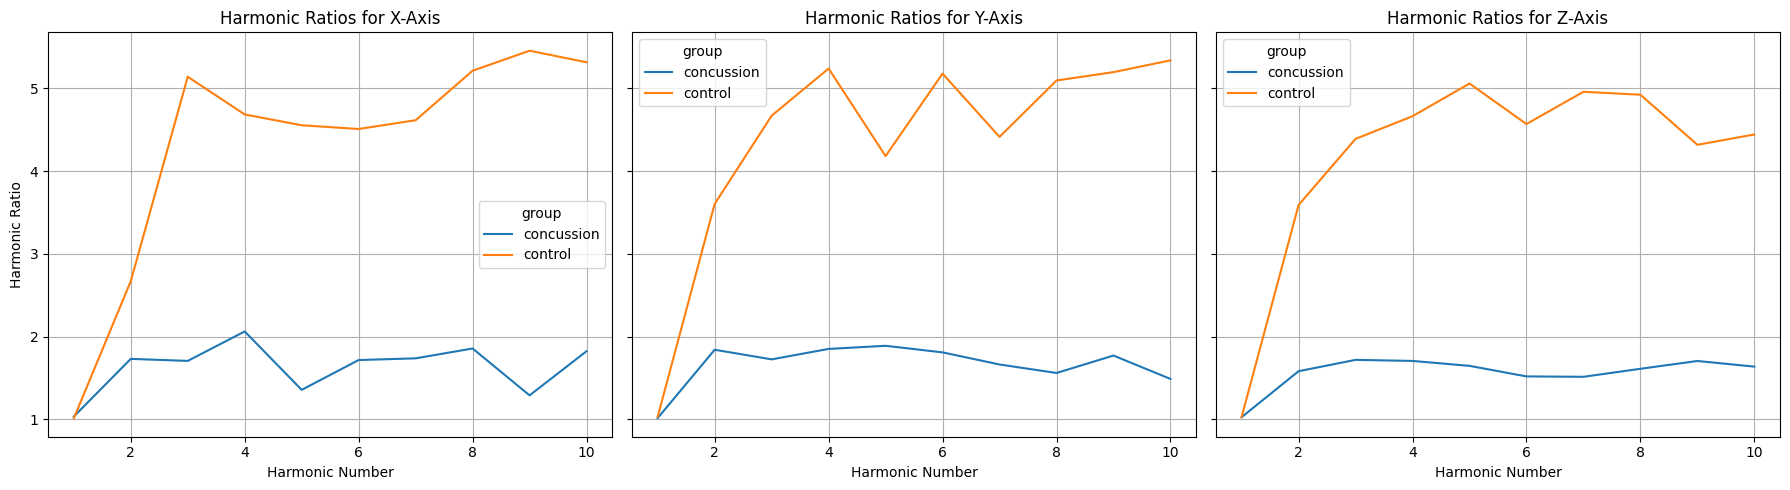

In [18]:
plot_harmonic_ratios(harmonics_df_dem)

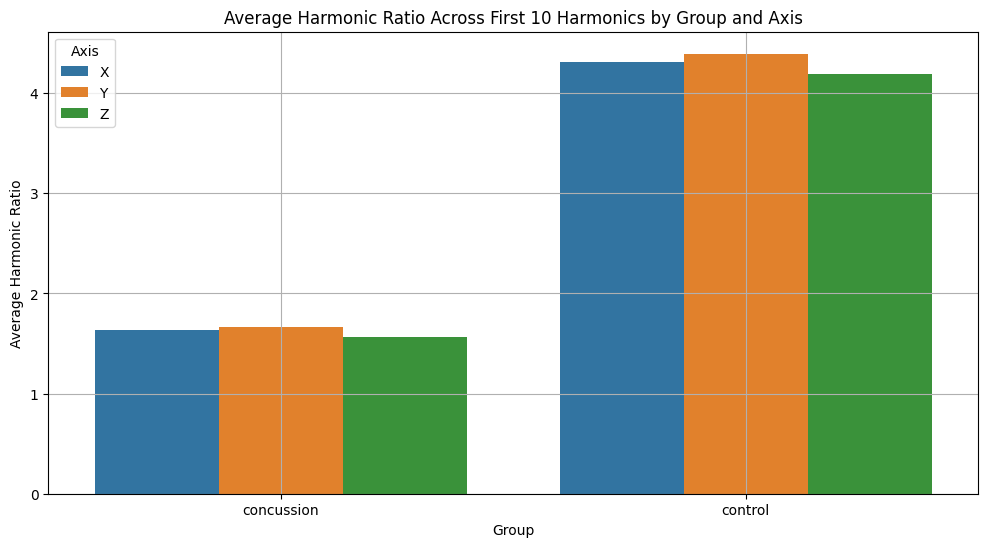

In [19]:
plot_average_harmonic_ratio_per_axis(harmonics_df_dem)

In [20]:
harmonics_df_dem_sub = harmonics_df_dem.groupby(['group', 'Axis'])['Harmonic_Ratio'].agg(['mean', 'std']).reset_index()
harmonics_df_dem_sub

,group,Axis,mean,std
0,concussion,X,1.630631,1.309311
1,concussion,Y,1.660668,0.897330
2,concussion,Z,1.565831,0.870434
3,control,X,4.315998,2.751699
4,control,Y,4.393986,2.767261
5,control,Z,4.193339,2.809559


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import pandas as pd
import numpy as np
import os

# Helper: load a random subject from each group
def load_random_subject(group_label):
    files = [f for f in os.listdir("synthetic_data") if group_label in f]
    chosen = np.random.choice(files)
    df = pd.read_csv(os.path.join("synthetic_data", chosen))
    df["Time"] = (df["Timestamp"] * 1).astype(int)
    return df.sort_values("Time").reset_index(drop=True), chosen

control_df, control_name = load_random_subject("control")
concuss_df, concuss_name = load_random_subject("concussion")

# Make time series consistent length
min_len = min(len(control_df), len(concuss_df))
control_df = control_df.iloc[:min_len]
concuss_df = concuss_df.iloc[:min_len]
time_steps = list(range(min_len))

# Set up 3D figure
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122, projection="3d")

for ax, title in zip([ax1, ax2], [f"Control: {control_name}", f"Concussion: {concuss_name}"]):
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])
    ax.set_zlim([5, 15])
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.set_title(title)

# Plot elements: path and moving dot
control_line, = ax1.plot([], [], [], 'b-', lw=2)
control_dot, = ax1.plot([], [], [], 'bo', markersize=6)

concuss_line, = ax2.plot([], [], [], 'r-', lw=2)
concuss_dot, = ax2.plot([], [], [], 'ro', markersize=6)

# Animation update function
def update(frame):
    x_c, y_c, z_c = control_df.loc[:frame, ["X", "Y", "Z"]].values.T
    control_line.set_data(x_c, y_c)
    control_line.set_3d_properties(z_c)
    control_dot.set_data([x_c[-1]], [y_c[-1]])
    control_dot.set_3d_properties([z_c[-1]])
    
    x_con, y_con, z_con = concuss_df.loc[:frame, ["X", "Y", "Z"]].values.T
    concuss_line.set_data(x_con, y_con)
    concuss_line.set_3d_properties(z_con)
    concuss_dot.set_data([x_con[-1]], [y_con[-1]])
    concuss_dot.set_3d_properties([z_con[-1]])
    
    fig.suptitle(f"Time step: {frame}", fontsize=14)
    return control_line, control_dot, concuss_line, concuss_dot

# Animate and save
ani = FuncAnimation(fig, update, frames=min_len, interval=100, blit=False)
os.makedirs("media", exist_ok=True)
output_path = "D:/sl3transfer2025/sharm/Projects/ds posts/harmonic_ratio/media/single_subjects_3d.gif"
ani.save(output_path, writer="pillow", fps=10)

plt.close(fig)
print(f"✅ Single-subject 3D animation saved to: {output_path}")


RMS

In [21]:
import numpy as np

def calculate_rms(series):
    """Calculate RMS value for a signal."""
    return np.sqrt(np.mean(series ** 2))

In [24]:
def process_rms(filepath):
    filename = os.path.basename(filepath)  
    df = pd.read_csv(filepath)
    
    # Treat Timestamp as float seconds, not dates
    df['Timestamp'] = pd.to_numeric(df['Timestamp'], errors='coerce')
    df = df.dropna(subset=['Timestamp'])

    # Convert to datetime index using start time offset
    start_time = pd.Timestamp.now().normalize()
    df['Timestamp'] = start_time + pd.to_timedelta(df['Timestamp'], unit='s')
    df.set_index('Timestamp', inplace=True)
    
    for col in ['X', 'Y', 'Z']:
        df[col] = bandpass_filter(df[col], lowcut=0.5, highcut=15, fs=30.1, order=3)
    
    # Add Vector Magnitude (VM)
    df["VM"] = np.sqrt(df["X"]**2 + df["Y"]**2 + df["Z"]**2)

    rms_minute = []

    minute_groups = df.resample('1min')
    for minute, group in minute_groups:
        result = {
            'Timeframe': minute,
            'Type': 'Per Minute',
            'subject': filename.split('.')[0] + '.gt3x',
            'group': 'concussion' if 'concussion' in filename else 'control'
        }
        for col in ['X', 'Y', 'Z', 'VM']:
            result[f'{col}_rms'] = calculate_rms(group[col])
        rms_minute.append(result)

    return pd.DataFrame(rms_minute)


In [25]:
# Run RMS processing for all subjects
rms_dfs = []
data_dir = "synthetic_data"
for file in os.listdir(data_dir):
    if file.endswith(".csv"):
        path = os.path.join(data_dir, file)
        rms_df = process_rms(path)
        rms_dfs.append(rms_df)

rms_all = pd.concat(rms_dfs)
rms_all['Minute'] = rms_all['Timeframe'].dt.minute

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import os

# Group RMS mean by time (minute) and group
grouped = (
    rms_all.groupby(['Minute', 'group'])[['X_rms', 'Y_rms', 'Z_rms']]
    .mean()
    .reset_index()
)

# Separate data by group
group_data = {
    group: grouped[grouped['group'] == group].sort_values('Minute')
    for group in ['control', 'concussion']
}

# Get frame count
n_frames = min(len(group_data['control']), len(group_data['concussion']))

# Setup figure
fig = plt.figure(figsize=(12, 6))
ax_ctrl = fig.add_subplot(121, projection='3d')
ax_conc = fig.add_subplot(122, projection='3d')

for ax, title in zip([ax_ctrl, ax_conc], ["Control", "Concussion"]):
    ax.set_xlim(0, grouped['X_rms'].max() * 1.1)
    ax.set_ylim(0, grouped['Y_rms'].max() * 1.1)
    ax.set_zlim(0, grouped['Z_rms'].max() * 1.1)
    ax.set_xlabel("X RMS")
    ax.set_ylabel("Y RMS")
    ax.set_zlabel("Z RMS")
    ax.set_title(title)

# Plot handles
ctrl_dot = ax_ctrl.plot([], [], [], 'bo')[0]
ctrl_line, = ax_ctrl.plot([], [], [], 'b--', alpha=0.6)

conc_dot = ax_conc.plot([], [], [], 'ro')[0]
conc_line, = ax_conc.plot([], [], [], 'r--', alpha=0.6)

# Storage for trails
ctrl_trail = {'x': [], 'y': [], 'z': []}
conc_trail = {'x': [], 'y': [], 'z': []}

# Animation function
def update(frame):
    minute = group_data['control']['Minute'].iloc[frame]
    
    for data, dot, line, trail, ax in zip(
        [group_data['control'], group_data['concussion']],
        [ctrl_dot, conc_dot],
        [ctrl_line, conc_line],
        [ctrl_trail, conc_trail],
        [ax_ctrl, ax_conc]
    ):
        row = data.iloc[frame]
        x, y, z = row['X_rms'], row['Y_rms'], row['Z_rms']
        
        trail['x'].append(x)
        trail['y'].append(y)
        trail['z'].append(z)
        
        dot.set_data([x], [y])
        dot.set_3d_properties([z])
        
        line.set_data(trail['x'], trail['y'])
        line.set_3d_properties(trail['z'])
    
    fig.suptitle(f"Mean RMS at Minute {minute}", fontsize=14)
    return ctrl_dot, conc_dot, ctrl_line, conc_line

# Run and save animation
os.makedirs("media", exist_ok=True)
ani = FuncAnimation(fig, update, frames=n_frames, interval=300, blit=False)
ani.save("media/rms_3d_motion.gif", writer='pillow', fps=2)
plt.close(fig)

print("✅ RMS 3D animation saved to media/rms_3d_motion.gif")


✅ RMS 3D motion plot with shared axes saved to media/rms_3d_motion_equal_axes.gif


In [32]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os

# Add group labels
harmonics_df['group'] = harmonics_df['Filename'].apply(
    lambda f: 'concussion' if 'concussion' in f else 'control'
)

# Use only the Z-axis and first 5 harmonics
axis = 'Z'
harmonics_sub = harmonics_df[
    (harmonics_df['Axis'] == axis) &
    (harmonics_df['Harmonic'] <= 5)
].copy()

# Group by subject and group
grouped = harmonics_sub.groupby(['group', 'subject', 'Harmonic'])['Amplitude'].mean().reset_index()

# Pivot to subject-level harmonic waveforms
control_subjects = grouped[grouped['group'] == 'control']['subject'].unique()
concussion_subjects = grouped[grouped['group'] == 'concussion']['subject'].unique()
n_frames = min(len(control_subjects), len(concussion_subjects))

control_frames = [
    grouped[(grouped['subject'] == subj) & (grouped['group'] == 'control')]
    for subj in control_subjects[:n_frames]
]

concussion_frames = [
    grouped[(grouped['subject'] == subj) & (grouped['group'] == 'concussion')]
    for subj in concussion_subjects[:n_frames]
]

# Set up figure
fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, title in zip([ax_left, ax_right], ["Control Group", "Concussion Group"]):
    ax.set_xlim(1, 5)
    ax.set_ylim(0, harmonics_sub['Amplitude'].max() * 1.2)
    ax.set_xlabel("Harmonic Number")
    ax.set_ylabel("Mean Amplitude")
    ax.set_title(title)

line_left, = ax_left.plot([], [], 'b-o')
line_right, = ax_right.plot([], [], 'r-o')

# Animation update
def update(frame):
    ctrl = control_frames[frame]
    conc = concussion_frames[frame]

    line_left.set_data(ctrl['Harmonic'], ctrl['Amplitude'])
    line_right.set_data(conc['Harmonic'], conc['Amplitude'])

    fig.suptitle(f"Group-Level Harmonic Profile – Frame {frame + 1}/{n_frames}", fontsize=14)
    return line_left, line_right

# Animate
ani = FuncAnimation(fig, update, frames=n_frames, interval=400, blit=False)
os.makedirs("media", exist_ok=True)
ani.save("media/group_harmonics_waveform.gif", writer='pillow', fps=2)
plt.close(fig)

print("✅ Group-level harmonic waveform saved to media/group_harmonics_waveform.gif")


✅ Group-level harmonic waveform saved to media/group_harmonics_waveform.gif


In [35]:
# ── Cell 1: BUILD TIME-AWARE GROUP-LEVEL HARMONICS DATAFRAME ────────────────

import os, glob
import pandas as pd
import numpy as np

records = []
data_dir = "synthetic_data"
axes = ['X','Y','Z']

for filepath in glob.glob(os.path.join(data_dir, "*.csv")):
    group = 'concussion' if 'concussion' in os.path.basename(filepath) else 'control'
    df = pd.read_csv(filepath)
    # Treat Timestamp as seconds, convert to datetime index
    df['Timestamp'] = pd.to_numeric(df['Timestamp'], errors='coerce')
    start = pd.Timestamp("2025-01-01")
    df['Datetime'] = start + pd.to_timedelta(df['Timestamp'], unit='s')
    df.set_index('Datetime', inplace=True)
    
    for axis in axes:
        # band-pass filter the signal
        sig = bandpass_filter(df[axis], lowcut=0.5, highcut=15, fs=30.1, order=3)
        # resample into 1-minute windows
        for ts, chunk in pd.Series(sig, index=df.index).resample('1Min'):
            vals = chunk.values
            if len(vals) < 2:
                continue
            # compute first N harmonics
            _, amps = harmonic_ratio(vals, fs=30.1)
            for hnum, amp in enumerate(amps[:5], start=1):
                records.append({
                    'Timeframe': ts,
                    'group': group,
                    'Axis': axis,
                    'Harmonic': hnum,
                    'Amplitude': amp
                })

# assemble and take group mean per window/axis/harmonic
harmonics_time_df = pd.DataFrame(records)
harmonics_ts_mean = (
    harmonics_time_df
    .groupby(['Timeframe','group','Axis','Harmonic'], as_index=False)['Amplitude']
    .mean()
)


C:\Users\sharm\AppData\Local\Temp\ipykernel_89236\2477039700.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,1,0.95])


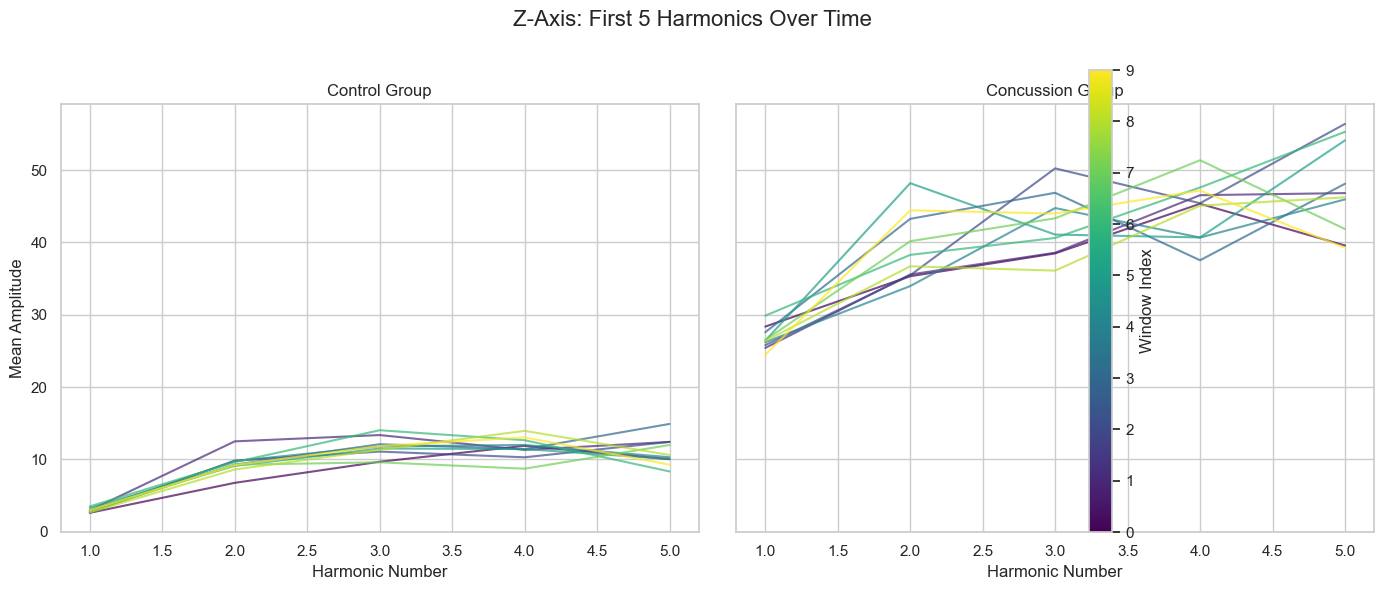

In [38]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# ── Prepare the data for plotting ────────────────────────────────────────────
axis = 'Z'
df = harmonics_ts_mean[
    (harmonics_ts_mean['Axis'] == axis) &
    (harmonics_ts_mean['Harmonic'] <= 5)
].copy()

# Pivot so rows = timeframes, cols = harmonics 1–5
df_ctrl = (df[df['group']=='control']
           .pivot(index='Timeframe', columns='Harmonic', values='Amplitude')
           .sort_index())
df_conc = (df[df['group']=='concussion']
           .pivot(index='Timeframe', columns='Harmonic', values='Amplitude')
           .sort_index())

# Set up a continuous colormap over the number of time windows
n = len(df_ctrl)
cmap = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=0, vmax=n-1)

# ── Plot ──────────────────────────────────────────────────────────────────────
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for i, (idx, row) in enumerate(df_ctrl.iterrows()):
    ax1.plot(df_ctrl.columns, row.values, color=cmap(norm(i)), alpha=0.7)
ax1.set_title('Control Group')
ax1.set_xlabel('Harmonic Number')
ax1.set_ylabel('Mean Amplitude')

for i, (idx, row) in enumerate(df_conc.iterrows()):
    ax2.plot(df_conc.columns, row.values, color=cmap(norm(i)), alpha=0.7)
ax2.set_title('Concussion Group')
ax2.set_xlabel('Harmonic Number')

# Add a colorbar to explain the time‐encoding
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=[ax1, ax2], orientation='vertical', label='Window Index')

plt.suptitle(f"{axis}-Axis: First 5 Harmonics Over Time", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


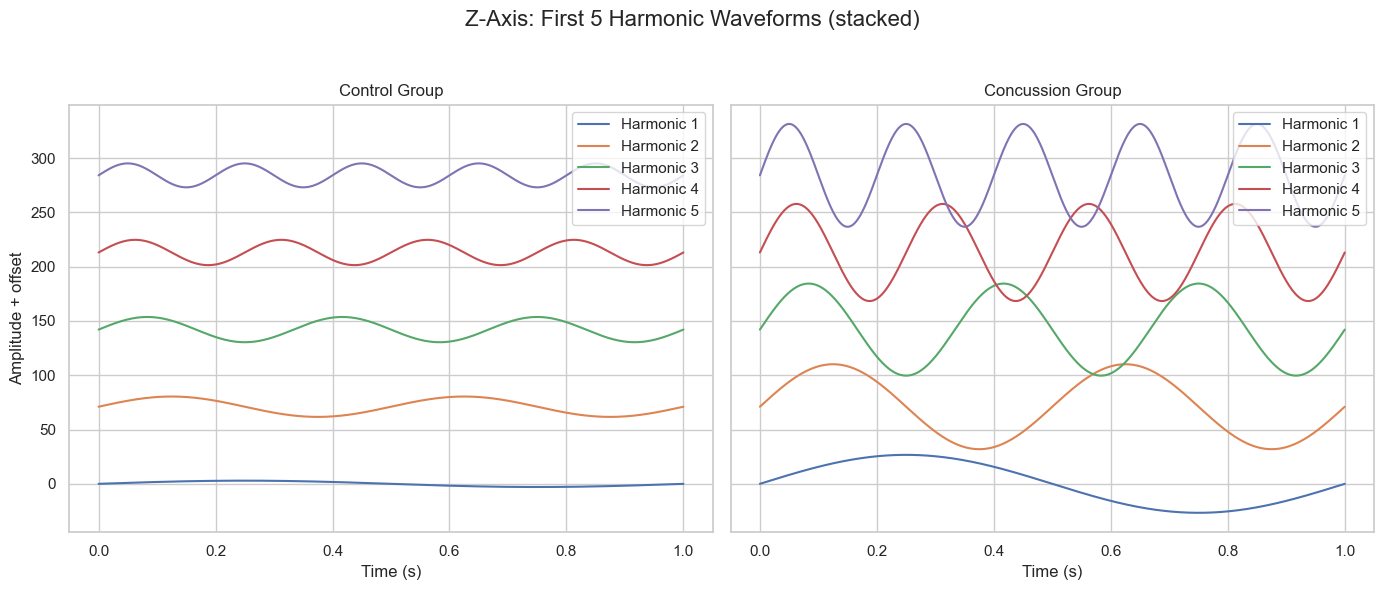

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# ——— 1) Compute overall group-mean amplitudes ——————————————————————————
axis = 'Z'
df = harmonics_ts_mean[
    (harmonics_ts_mean['Axis'] == axis) &
    (harmonics_ts_mean['Harmonic'] <= 5)
]

meanamps = (
    df
    .groupby(['group','Harmonic'])['Amplitude']
    .mean()
    .reset_index()
)

ctrl_amps = meanamps[meanamps['group']=='control'].sort_values('Harmonic')['Amplitude'].values
conc_amps = meanamps[meanamps['group']=='concussion'].sort_values('Harmonic')['Amplitude'].values

# ——— 2) Reconstruct sine waves ——————————————————————————————————————
f0 = 1.0  # fundamental frequency in Hz
t = np.linspace(0, 1, 1000)

# maximum amplitude to use for vertical stacking
max_amp = max(ctrl_amps.max(), conc_amps.max())
offset = max_amp * 1.5

ctrl_waves = [A * np.sin(2*np.pi*(n+1)*f0 * t) + n*offset
              for n, A in enumerate(ctrl_amps)]
conc_waves = [A * np.sin(2*np.pi*(n+1)*f0 * t) + n*offset
              for n, A in enumerate(conc_amps)]

# ——— 3) Plot stacked sine waves side-by-side —————————————————————————
fig, (ax_l, ax_r) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Control
for n, wave in enumerate(ctrl_waves, start=1):
    ax_l.plot(t, wave, label=f"Harmonic {n}")
ax_l.set_title("Control Group")
ax_l.set_xlabel("Time (s)")
ax_l.set_ylabel("Amplitude + offset")
ax_l.legend(loc="upper right")

# Concussion
for n, wave in enumerate(conc_waves, start=1):
    ax_r.plot(t, wave, label=f"Harmonic {n}")
ax_r.set_title("Concussion Group")
ax_r.set_xlabel("Time (s)")
ax_r.legend(loc="upper right")

plt.suptitle(f"{axis}-Axis: First 5 Harmonic Waveforms (stacked)", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()
